In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from os import environ
environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'

%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark import SparkContext
import string
import nltk
from nltk.corpus import stopwords 

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

DATA_DIR = 'data/'

# IMDB Data 

We'll be using four of the IMDB datasets: 
1. basics - for various metadata about the movie/tv series
* episode - to match the subtitles tv series episodes with the overall series in the database
* ratings - for the ratings and views info

All of them are available for dowload and described here: [IMDb](https://www.imdb.com/interfaces/).

In [2]:
# Loads the IMDb datasets
basics = spark.read.csv(DATA_DIR + 'title.basics.tsv.gz', sep='\t', header=True, nanValue="\\N")
episode = spark.read.csv(DATA_DIR + 'title.episode.tsv.gz', sep='\t', header=True)
ratings = spark.read.csv(DATA_DIR + 'title.ratings.tsv.gz', sep='\t', header=True)

In [3]:
basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
episode.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- parentTconst: string (nullable = true)
 |-- seasonNumber: string (nullable = true)
 |-- episodeNumber: string (nullable = true)



In [5]:
ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)



We only need the following fields from every table:
* basics:
    * all fields withouth isAdult, originalTitle
* episode:
    * all fields
* ratings:
    * all fields

In [6]:
basics.select('titleType').distinct().show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



We're not interested in the `videoGame`, `video`, `tvShort` or `short` types, thus we filter them out.

In [7]:
# Removes the originalTitle and isAdult columns
basics = basics.drop('isAdult', 'originalTitle').filter(col('titleType') != 'short').filter(
    col('titleType') != 'videoGame').filter(col('titleType') != 'tvShort').filter(col('titleType') != 'videos')

# Removes episodes with empty series or episode numbers
episode = episode.filter(col('seasonNumber') != '\\N').filter(col('episodeNumber') != '\\N').withColumnRenamed("tconst", "episodeTconst")

In [8]:
# Note that we leave the endYear column because it is valid for the TV Series, e.x.
basics.filter(col('primaryTitle') == 'Twin Peaks').show(5)

+---------+---------+------------+---------+-------+--------------+--------------------+
|   tconst|titleType|primaryTitle|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+------------+---------+-------+--------------+--------------------+
|tt0098936| tvSeries|  Twin Peaks|     1990|   1991|            47| Crime,Drama,Mystery|
|tt0186641|    video|  Twin Peaks|     1993|     \N|            \N|               Adult|
|tt2395641|tvEpisode|  Twin Peaks|     2006|     \N|            \N|         Documentary|
|tt2650780|tvEpisode|  Twin Peaks|     2013|     \N|            44|Adventure,Reality-TV|
|tt3225942|tvEpisode|  Twin Peaks|     2013|     \N|            43|          Reality-TV|
+---------+---------+------------+---------+-------+--------------+--------------------+
only showing top 5 rows



In [9]:
basics.show(5)

+---------+---------+--------------------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|     1906|     \N|            70|Biography,Crime,D...|
+---------+---------+--------------------+---------+-------+--------------+--------------------+
only showing top 5 rows



In [10]:
episode.show(5)

+-------------+------------+------------+-------------+
|episodeTconst|parentTconst|seasonNumber|episodeNumber|
+-------------+------------+------------+-------------+
|    tt0041951|   tt0041038|           1|            9|
|    tt0042816|   tt0989125|           1|           17|
|    tt0043426|   tt0040051|           3|           42|
|    tt0043631|   tt0989125|           2|           16|
|    tt0043693|   tt0989125|           2|            8|
+-------------+------------+------------+-------------+
only showing top 5 rows



In [11]:
ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1445|
|tt0000002|          6.4|     174|
|tt0000003|          6.6|    1042|
|tt0000004|          6.4|     104|
|tt0000005|          6.2|    1742|
+---------+-------------+--------+
only showing top 5 rows



We separate the movies and TV series, as they need to be processed differently.

Number of movies in the IMDb database: 505391


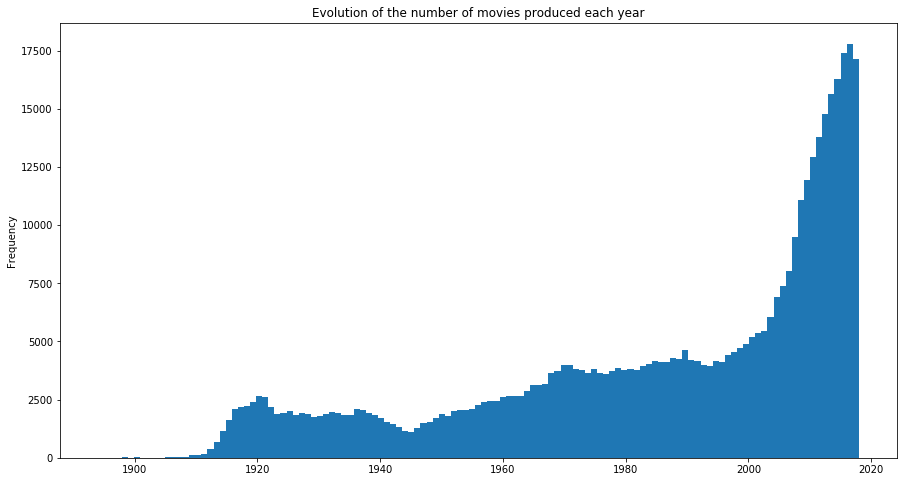

In [12]:
movies = basics.filter(basics.titleType == "movie")

movies_years = movies.select("startYear").toPandas()["startYear"].dropna()
print("Number of movies in the IMDb database: {}".format(movies.count()))

# We cast the defined years to int
movies_years = movies_years[movies_years != "\\N"].astype(int)

# We plot the histogram only for already released movies (a.k.a. movies that were released in or before 2018)
movies_years = movies_years[movies_years <= 2018]
movies_years.plot(kind="hist", bins=movies_years.max() - movies_years.min() + 1, figsize=(15,8),
                  title="Evolution of the number of movies produced each year");
plt.savefig('docs/img/movies_evolution.png', transparent=True)

Number of TV series in the IMDb database: 156890


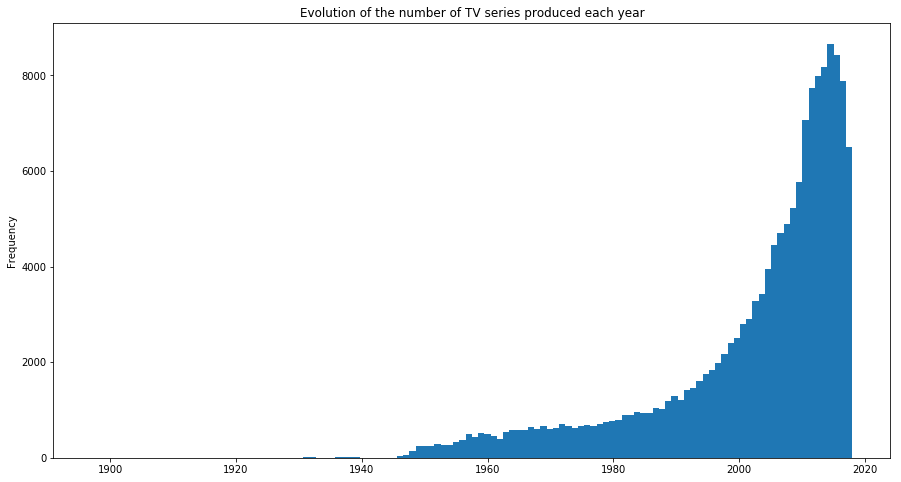

In [13]:
tvseries = basics.filter(((basics.titleType == "tvSeries") | (basics.titleType == "miniTvSeries")))
tvseries_years = tvseries.toPandas()["startYear"].dropna()
print("Number of TV series in the IMDb database: {}".format(tvseries.count()))

# We cast the defined years to int
tvseries_years = tvseries_years[tvseries_years != "\\N"].astype(int)

# We plot the histogram only for already released tv series (a.k.a. tv series that were released in or before 2018)
tvseries_years = tvseries_years[tvseries_years <= 2018]
tvseries_years.plot(kind="hist", bins=tvseries_years.max() - tvseries_years.min() + 1, figsize=(15,8),
                  title="Evolution of the number of TV series produced each year");
plt.savefig('docs/img/tv_series_evolution.png', transparent=True)

In [14]:
movies = movies.join(ratings, "tconst")

# Due to the way the structure of the OpenSubtitles dataset (require us to load one subtitle file per episode),
# we will only extract the topics on the first episode of each tv series (the pilot)
pilots = episode.filter(episode.seasonNumber == 1).filter(episode.episodeNumber == 1)
tvseries = tvseries.join(ratings, "tconst")
tvseries = tvseries.join(pilots, tvseries.tconst == pilots.parentTconst)

In [15]:
movies_col = ["tconst", "startYear", "genres", "averageRating", "numVotes"]
tvseries_col = ["tconst", "startYear", "genres", "averageRating", "numVotes", "episodeTconst"]
# According to IMDb database, ratings are only relevant when there are more than 5000 votes.
movies_relevant = movies.filter(movies.numVotes > 5000).select(*movies_col)
print("Number of relevant movies: {}".format(movies_relevant.count()))
tvseries_relevant = tvseries.filter(tvseries.numVotes > 5000).select(*tvseries_col)
print("Number of relevant TV series: {}".format(tvseries_relevant.count()))

Number of relevant movies: 11440
Number of relevant TV series: 1524


In [16]:
movies_relevant.write.parquet("movies.parquet", mode="overwrite")
tvseries_relevant.write.parquet("tvseries.parquet", mode="overwrite")

# Subtitle data

## Extracting the subtitles data

**This part of the notebook is reserved for the subtitle data collection. Considering the data set is 31 GB long, the code below was ran on the cluster (and thus cannot be ran on this notebook).**

In [17]:
# TODO

## Processing

In [18]:
# TODO

# Cost and gross analysis

In order to show the importance of both the movie industry to introduce our data story, we wanted to highlight the evolution of production costs and yearly box-office, however, these data, which are present on IMDb, required us to register for a professional and paying account, thus we found a summary table on [The Numbers](https://www.the-numbers.com/movies/#tab=year), which even though it doesn't have as much details as the IMDb database, still shows pretty well the exponential evolution over the last century.

In [19]:
box_office = pd.read_csv("data/box_office.csv", delimiter=";")
box_office.head(10)

,Year,Total Movies,Average Production Budget,Combined Worldwide Box Office,No. 1 Movie
0,TBD,"1,782",NaN,NaN,NaN
1,2025,1,NaN,NaN,NaN
2,2024,1,NaN,NaN,NaN
3,2023,2,NaN,NaN,NaN
4,2022,16,NaN,NaN,NaN
5,2021,28,NaN,NaN,NaN
6,2020,87,"$112,500,000",NaN,NaN
7,2019,371,"$36,268,750",NaN,NaN
8,2018,"4,391","$57,176,887","$32,270,167,911",Avengers: Infinity War
9,2017,"3,957","$54,517,823","$37,661,783,041",Star Wars Ep. VIII: The Last Jedi


In [20]:
# Removes the TBD row, as well as the years that have not been reached yets (years bigger than 2018)
box_office.drop(range(0, 8), axis=0, inplace=True)

# Casts the year to integers
box_office["Year"] = box_office["Year"].astype(int)

# Fills all the missing number with value 0
box_office.fillna("0",inplace=True)

# Removes the year that have not been reached yet
box_office.head(5)

,Year,Total Movies,Average Production Budget,Combined Worldwide Box Office,No. 1 Movie
8,2018,"4,391","$57,176,887","$32,270,167,911",Avengers: Infinity War
9,2017,"3,957","$54,517,823","$37,661,783,041",Star Wars Ep. VIII: The Last Jedi
10,2016,"3,663","$42,323,318","$36,759,537,509",Captain America: Civil War
11,2015,"3,126","$26,808,427","$35,988,293,278",Star Wars Ep. VII: The Force Awakens
12,2014,"1,632","$30,252,500","$29,907,642,297",Transformers: Age of Extinction


In [21]:
box_office["Average Production Budget"] = box_office["Average Production Budget"].str.replace("[$,]", '').astype(
    float) / 10 ** 6
box_office["Combined Worldwide Box Office"] = box_office["Combined Worldwide Box Office"].str.replace(
    "[$,]",'').astype(int) / 10 ** 9
box_office["Total Movies"] = box_office["Total Movies"].str.replace(",",'').astype(int)
box_office["Yearly Budget"] = box_office["Average Production Budget"] * box_office["Total Movies"] / 10**3
box_office.head(5)

,Year,Total Movies,Average Production Budget,Combined Worldwide Box Office,No. 1 Movie,Yearly Budget
8,2018,4391,57.176887,32.270168,Avengers: Infinity War,251.063711
9,2017,3957,54.517823,37.661783,Star Wars Ep. VIII: The Last Jedi,215.727026
10,2016,3663,42.323318,36.759538,Captain America: Civil War,155.030314
11,2015,3126,26.808427,35.988293,Star Wars Ep. VII: The Force Awakens,83.803143
12,2014,1632,30.252500,29.907642,Transformers: Age of Extinction,49.372080


In [22]:
years = box_office["Year"].values
average_budget = box_office["Average Production Budget"].values
movies = box_office["Total Movies"].values
bo = box_office["Combined Worldwide Box Office"].values
budget = box_office["Yearly Budget"].values

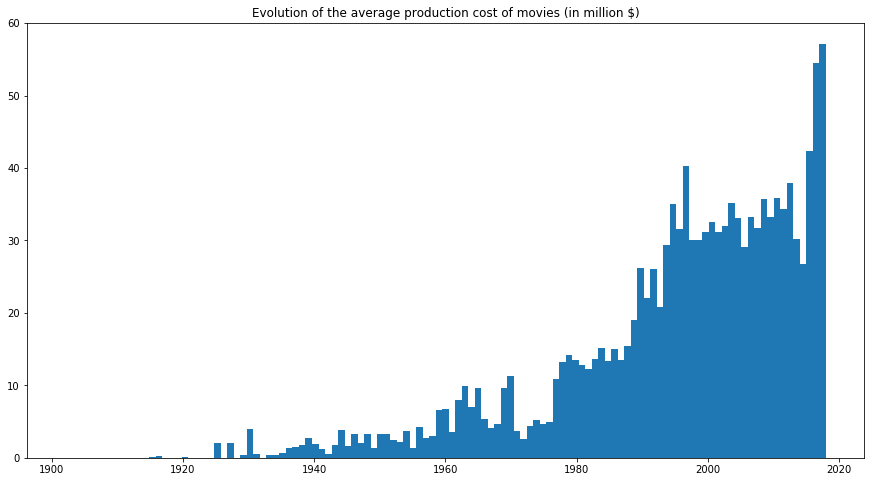

In [23]:
plt.figure(figsize=(15, 8))
plt.hist(years, weights=average_budget, bins=(years.max() - years.min()+1))
plt.title("Evolution of the average production cost of movies (in million $)")
plt.savefig('docs/img/average_production_costs.png', transparent=True)

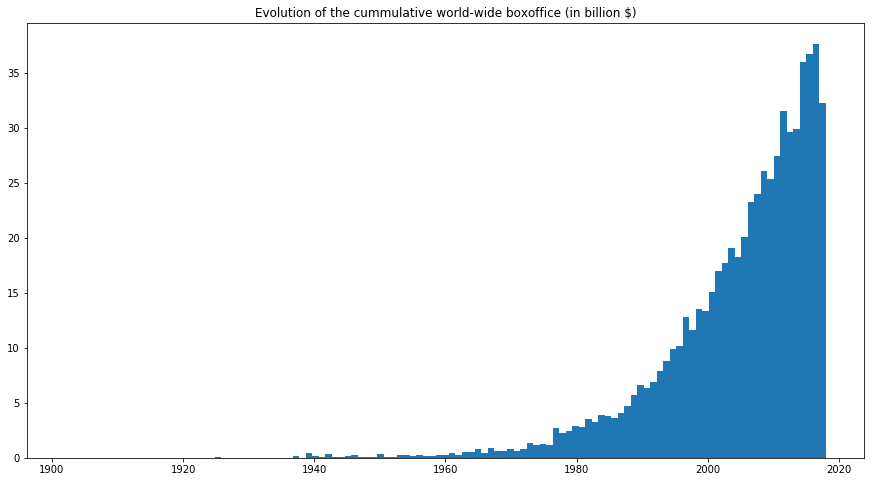

In [24]:
plt.figure(figsize=(15, 8))
plt.hist(years, weights=bo, bins=(years.max() - years.min()+1))
plt.title("Evolution of the cummulative world-wide boxoffice (in billion $)")
plt.savefig('docs/img/box_office.png', transparent=True)

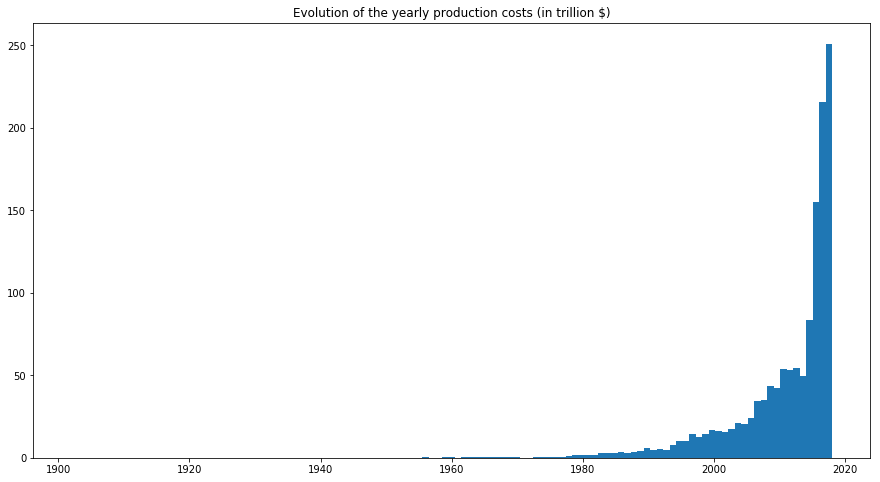

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(years, weights=budget, bins=(years.max() - years.min()+1))
plt.title("Evolution of the yearly production costs (in trillion $)")
plt.savefig('docs/img/production_costs.png', transparent=True)